<h1 style='font-size: 35px; color: navy; font-family: Dalton White; font-weight: 600; text-align: center'>Compact Letter Display (CLD)</h1>

---

<h1 style='font-family: Manilla Script; font-weight: 600; font-size: 20px; text-align: left'>1.0. Import Required Libraries</h1>

In [53]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols as smf_ols 
from statsmodels.stats.anova import anova_lm 
import statsmodels.formula.api as smf
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import string
import math
import re

import warnings
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', 10)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print("\n----- Libraries Loaded Successfully -----\n")


----- Libraries Loaded Successfully -----



<h1 style='font-family: Manilla Script; font-weight: 600; font-size: 20px; text-align: left'>2.0. Load and Inspect Dataset</h1>

In [4]:
filepath = "Datasets/Eggplant Fusarium Fresistance Data.csv"
df = pd.read_csv(filepath)
display(df)

,Variety,Resistance Level,Replication ID,Infection Severity (%),Wilt index,Plant height (cm),Days to wilt symptoms,Survival rate (%),Disease incidence (%)
0,EP-R1,Resistant,1,22.50,0.70,88.90,21,88.80,23.40
1,EP-R1,Resistant,2,27.90,1.20,82.20,19,87.70,21.70
2,EP-R1,Resistant,3,21.20,0.00,74.70,17,84.90,27.20
3,EP-R1,Resistant,4,15.50,0.10,93.80,18,90.30,15.00
4,EP-R1,Resistant,5,17.30,0.90,78.10,19,87.00,23.00
...,...,...,...,...,...,...,...,...,...
795,EP-S3,Susceptible,96,75.20,3.60,68.20,7,6.40,85.50
796,EP-S3,Susceptible,97,74.80,4.90,59.50,4,27.20,82.00
797,EP-S3,Susceptible,98,58.10,3.60,78.80,7,30.80,75.40
798,EP-S3,Susceptible,99,54.10,4.10,63.70,7,24.10,81.80


<h1 style='font-family: Manilla Script; font-size: 25px; font-weight: 600'> 3.0: Data Overview & Quality Checks</h1>

<h4 style='font-family: Manilla Script; font-size: 20px; font-weight: 600'> 3.1: Columns Profiling</h4>

In [46]:
def column_summaries(df: pd.DataFrame) -> pd.DataFrame:
    summary_data = []
    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()
        
        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts
        })
    
    summary_df = pd.DataFrame(summary_data)
    return summary_df
    
if __name__ == "__main__":
    summary_df = column_summaries(df)
    display(summary_df)

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,Variety,object,0,800,8,"{'EP-R1': 100, 'EP-R2': 100, 'EP-R3': 100, 'EP..."
1,Resistance Level,object,0,800,3,"{'Resistant': 300, 'Susceptible': 300, 'Modera..."
2,Replication ID,int64,0,800,100,"{1: 8, 2: 8, 3: 8, 4: 8, 5: 8, 6: 8, 7: 8, 8: ..."
3,Infection Severity (%),float64,0,800,473,"{21.4: 6, 22.6: 6, 21.2: 6, 19.1: 6, 21.3: 5, ..."
4,Wilt index,float64,0,800,51,"{5.0: 31, 4.3: 26, 4.0: 25, 0.5: 24, 0.9: 24, ..."
5,Plant height (cm),float64,0,800,345,"{72.0: 9, 85.6: 6, 72.8: 6, 85.1: 6, 79.1: 6, ..."
6,Days to wilt symptoms,int64,0,800,20,"{7: 115, 8: 66, 6: 64, 19: 60, 12: 58, 18: 53,..."
7,Survival rate (%),float64,0,800,488,"{100.0: 7, 90.4: 6, 85.0: 6, 86.9: 5, 29.0: 5,..."
8,Disease incidence (%),float64,0,800,492,"{82.7: 6, 78.9: 5, 84.0: 5, 24.0: 4, 83.5: 4, ..."


<h4 style='font-family: Manilla Script; font-size: 20px; font-weight: 600'> 3.2: Dataset Shape and Columns</h4>

In [6]:
nrows, ncols = df.shape
print(f"Dataset has {nrows} entries and {ncols} columns")

Dataset has 800 entries and 9 columns


In [7]:
for i, column in enumerate(df.columns.tolist()): print(f"{'-'*5} {i}: {column}")

----- 0: Variety
----- 1: Resistance Level
----- 2: Replication ID
----- 3: Infection Severity (%)
----- 4: Wilt index
----- 5: Plant height (cm)
----- 6: Days to wilt symptoms
----- 7: Survival rate (%)
----- 8: Disease incidence (%)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Variety                 800 non-null    object 
 1   Resistance Level        800 non-null    object 
 2   Replication ID          800 non-null    int64  
 3   Infection Severity (%)  800 non-null    float64
 4   Wilt index              800 non-null    float64
 5   Plant height (cm)       800 non-null    float64
 6   Days to wilt symptoms   800 non-null    int64  
 7   Survival rate (%)       800 non-null    float64
 8   Disease incidence (%)   800 non-null    float64
dtypes: float64(5), int64(2), object(2)
memory usage: 56.4+ KB


<h4 style='font-family: Manilla Script; font-size: 20px; font-weight: 600'> 3.4: Checking Missing Values</h4>

In [45]:
def isna_info(df: pd.DataFrame) -> pd.DataFrame:
    miss = df.isna().sum().reset_index(name='Counts')
    miss['Proportions (%)'] = miss['Counts']/len(df)*100
    return miss
    
if __name__ == "__main__":
    isna_info = isna_info(df)
    display(isna_info)

,index,Counts,Proportions (%)
0,Variety,0,0.00
1,Resistance Level,0,0.00
2,Replication ID,0,0.00
3,Infection Severity (%),0,0.00
4,Wilt index,0,0.00
5,Plant height (cm),0,0.00
6,Days to wilt symptoms,0,0.00
7,Survival rate (%),0,0.00
8,Disease incidence (%),0,0.00


<h4 style='font-family: Manilla Script; font-size: 20px; font-weight: 600'> 3.5: Exploring Invalid Dtypes Entries</h4>

In [44]:
def simplify_dtype(dtype: str):
    if dtype in (int, float, np.number): return 'Numeric'
    elif np.issubdtype(dtype, np.datetime64): return 'Datetime'
    elif dtype == str: return 'String'
    elif dtype == type(None): return 'Missing'
    else: return 'Other'

def analyze_column_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    all_dtypes = {'Numeric', 'Datetime', 'String', 'Missing', 'Other'}
    results = pd.DataFrame(index=df.columns, columns=list(all_dtypes), dtype=object).fillna('-')
    
    for column in df.columns:
        dtypes = df[column].apply(lambda x: simplify_dtype(type(x))).value_counts()
        percentages = (dtypes / len(df)) * 100
        for dtype, percent in percentages.items():
            if percent > 0:
                results.at[column, dtype] = f'{percent:.2f}%'  # Add % sign and format to 2 decimal places
            else:
                results.at[column, dtype] = '-'  # Add dash for 0%
    return results

if __name__ == "__main__":
    results = analyze_column_dtypes(df)
    display(results)

,Numeric,Other,Missing,Datetime,String
Variety,-,-,-,-,100.00%
Resistance Level,-,-,-,-,100.00%
Replication ID,100.00%,-,-,-,-
Infection Severity (%),100.00%,-,-,-,-
Wilt index,100.00%,-,-,-,-
Plant height (cm),100.00%,-,-,-,-
Days to wilt symptoms,100.00%,-,-,-,-
Survival rate (%),100.00%,-,-,-,-
Disease incidence (%),100.00%,-,-,-,-


<h1 style='font-family: Manilla Script; font-size: 25px; font-weight: 600'>4.0: Analysis of Varience | Post-Hoc Analysis</h1>

<h3 style='font-family: Manilla Script; font-size: 20px; font-weight: 600'>4.1: One Way  Analysis of Varience</h3>

In [55]:
def starndardize_name(text): return re.sub(r'[^a-zA-Z]', "", text)
    
def one_way_anova(df: pd.DataFrame, num_variables: list, group_cols: list) -> pd.DataFrame:
    results = []
    original_group_cols = group_cols[:]
    group_cols = [starndardize_name(col) for col in group_cols]
    df = df.rename(columns={col: starndardize_name(col) for col in df.columns})
    
    for original_group, group in zip(original_group_cols, group_cols):
        for col in num_variables:
            column_name = starndardize_name(col)  
            formula = f"{column_name} ~ C({group})" 
            model = smf.ols(formula, data=df).fit()
            anova_table = sm.stats.anova_lm(model, typ=2)
            
            for source, row in anova_table.iterrows():
                p_value = row["PR(>F)"]
                interpretation = "Significant" if p_value < 0.05 else "No significant"
                if source == "Residual":
                    interpretation = "-"
                
                results.append({
                    "Variable": col,
                    "Source": source,
                    "Sum Sq": row["sum_sq"],
                    "df": row["df"],
                    "F-Value": row["F"],
                    "p-Value": p_value,
                    "Interpretation": interpretation
                })

    return pd.DataFrame(results)

if __name__ == "__main__":
    FACTORS = ['Variety']
    ANALYSIS_METRICS = df.select_dtypes(include=[np.number]).columns.tolist()
    results = one_way_anova(df, ANALYSIS_METRICS, FACTORS)
    display(results)

,Variable,Source,Sum Sq,df,F-Value,p-Value,Interpretation
0,Replication ID,C(Variety),0.00,7.00,0.00,1.00,No significant
1,Replication ID,Residual,666600.00,792.00,NaN,NaN,-
2,Infection Severity (%),C(Variety),432094.82,7.00,897.47,0.00,Significant
3,Infection Severity (%),Residual,54473.51,792.00,NaN,NaN,-
4,Wilt index,C(Variety),1705.22,7.00,730.61,0.00,Significant
5,Wilt index,Residual,264.07,792.00,NaN,NaN,-
6,Plant height (cm),C(Variety),59239.97,7.00,293.62,0.00,Significant
7,Plant height (cm),Residual,22827.23,792.00,NaN,NaN,-
8,Days to wilt symptoms,C(Variety),19302.91,7.00,1091.56,0.00,Significant
9,Days to wilt symptoms,Residual,2000.79,792.00,NaN,NaN,-


<H3 style='font-family: Manilla Script; font-size: 20px; font-weight: 600'>4.2: Tukey's Honest Significant Difference (THSD)</H3>

In [48]:
def tukey_hsd_result(df: pd.DataFrame, variables: list, group: str) -> pd.DataFrame:
    results_data = []
    for variable in variables:
        turkey_results = pairwise_tukeyhsd(endog=df[variable], groups=df[group], alpha=0.05)
        results_table = turkey_results.summary()
        
        for i in range(1, len(results_table)):
            row = results_table.data[i]
            results_data.append({
                "Factor": group,
                'Variable': variable,
                'Group1': row[0],
                'Group2': row[1],
                'Mean Diff.': row[2],
                'P-Value': row[3],
                'Lower CI': row[4],
                'Upper CI': row[5],
                'Reject Null': row[6]
            })
        
        result_df = pd.DataFrame(results_data)
    return result_df

if __name__ == "__main__":
    FACTOR = 'Variety'
    ANALYSIS_METRICS = df.select_dtypes(include=[np.number]).columns.tolist()
    results = tukey_hsd_result(df, ANALYSIS_METRICS, FACTOR)
    display(results)

,Factor,Variable,Group1,Group2,Mean Diff.,P-Value,Lower CI,Upper CI,Reject Null
0,Variety,Replication ID,EP-M1,EP-M2,0.00,1.00,-12.47,12.47,False
1,Variety,Replication ID,EP-M1,EP-R1,0.00,1.00,-12.47,12.47,False
2,Variety,Replication ID,EP-M1,EP-R2,0.00,1.00,-12.47,12.47,False
3,Variety,Replication ID,EP-M1,EP-R3,0.00,1.00,-12.47,12.47,False
4,Variety,Replication ID,EP-M1,EP-S1,0.00,1.00,-12.47,12.47,False
...,...,...,...,...,...,...,...,...,...
191,Variety,Disease incidence (%),EP-R3,EP-S2,54.32,0.00,51.05,57.59,True
192,Variety,Disease incidence (%),EP-R3,EP-S3,55.55,0.00,52.28,58.82,True
193,Variety,Disease incidence (%),EP-S1,EP-S2,-1.67,0.78,-4.94,1.60,False
194,Variety,Disease incidence (%),EP-S1,EP-S3,-0.45,1.00,-3.72,2.82,False


<h2 style='font-family: Manilla Script; font-size: 20px; font-weight: 600'>4.3: Tukey's Honest Significant Difference (THSD) Results Visualization</h2>


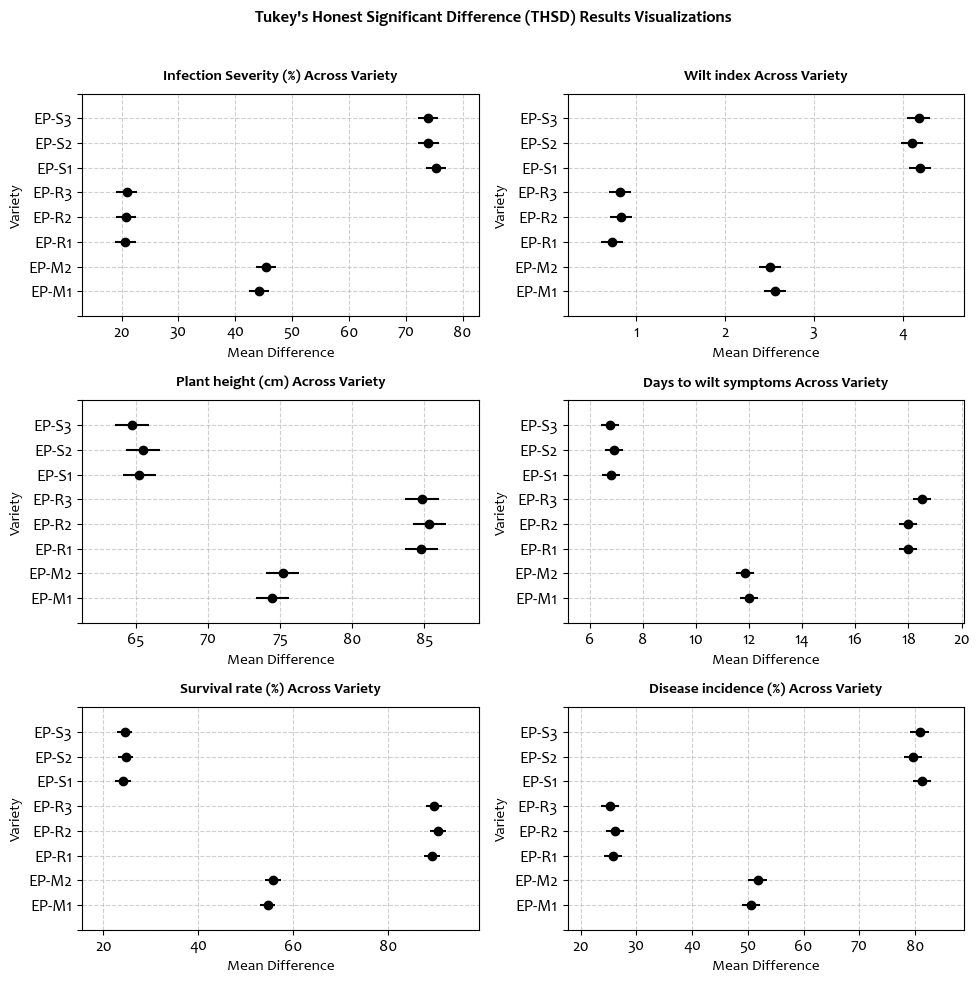

In [49]:
def visualize_tukey_hsd(df: pd.DataFrame, variables: list, group: str):
    num_variables = len(variables)
    rows = math.ceil(num_variables / 2)
    cols = min(num_variables, 2)

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    plt.rcParams.update({'font.family': 'Candara', 'font.style': 'normal', 'font.size': 11})
    fig.suptitle("Tukey's Honest Significant Difference (THSD) Results Visualizations", fontsize=12, fontweight='bold')
    axes = axes.flatten() if num_variables > 1 else [axes]

    for idx, column in enumerate(variables):
        tukey_result = pairwise_tukeyhsd(df[column], df[group], alpha=0.05)
        tukey_result.plot_simultaneous(figsize=(10,10), ax=axes[idx])
        axes[idx].set_title(f"{column} Across {group}", fontsize=11, pad=10, fontweight='bold')
        axes[idx].set_xlabel("Mean Difference", fontsize=11)
        axes[idx].set_ylabel(group, fontsize=11)
        axes[idx].grid(linestyle="--", alpha=0.6)

    for idx in range(num_variables, len(axes)):fig.delaxes(axes[idx])
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    return fig
    
if __name__ == "__main__":
    FACTOR = 'Variety'
    ANALYSIS_METRICS = df.select_dtypes(include=[np.number]).columns.tolist()[1:]
    fig = visualize_tukey_hsd(df, ANALYSIS_METRICS, FACTOR)

<h1 style='font-family: Manilla Script; font-size: 25px; font-weight: 600'>5.0: Compact Letter Display (CLD) </h1>

<h2 style='font-family: Manilla Script; font-size: 20px; font-weight: 600'>5.1: Algorithim to Assign Letters </h2>

In [34]:
def letters(df, alpha=0.05):
    df["p-adj"] = df["p-adj"].astype(float)
    group1 = set(df.group1.tolist())
    group2 = set(df.group2.tolist())
    groupSet = group1 | group2
    groups = list(groupSet)
    letters = list(string.ascii_lowercase)[:len(groups)]
    cldgroups = letters
    cld = pd.DataFrame(list(zip(groups, letters, cldgroups)))
    cld[3] = ""
    
    for row in df.itertuples():
        if df["p-adj"][row[0]] > alpha:
            cld.loc[groups.index(df["group1"][row[0]]), 2] += cld.loc[groups.index(df["group2"][row[0]]), 1]
            cld.loc[groups.index(df["group2"][row[0]]), 2] += cld.loc[groups.index(df["group1"][row[0]]), 1]
        if df["p-adj"][row[0]] < alpha:
            cld.loc[groups.index(df["group1"][row[0]]), 3] += cld.loc[groups.index(df["group2"][row[0]]), 1]
            cld.loc[groups.index(df["group2"][row[0]]), 3] += cld.loc[groups.index(df["group1"][row[0]]), 1]
    
    cld[2] = cld[2].apply(lambda x: "".join(sorted(x)))
    cld[3] = cld[3].apply(lambda x: "".join(sorted(x)))
    cld.rename(columns={0: "groups"}, inplace=True)
    cld = cld.sort_values(cld.columns[2], key=lambda x: x.str.len())
    cld["labels"] = ""
    letters = list(string.ascii_lowercase)
    unique = []
    
    for item in cld[2]:
        for fitem in cld["labels"].unique():
            for c in range(len(fitem)):
                if not set(unique).issuperset(set(fitem[c])):
                    unique.append(fitem[c])
        g = len(unique)
        for kitem in cld[1]:
            if kitem in item:
                if cld.loc[cld[1] == kitem, "labels"].iloc[0] == "":
                    cld.loc[cld[1] == kitem, "labels"] += letters[g]
                if kitem in " ".join(cld.loc[cld["labels"] == letters[g], 3]):
                    g = len(unique) + 1
                if len(set(cld.loc[cld[1] == kitem, "labels"].iloc[0]).intersection(cld.loc[cld[2] == item, "labels"].iloc[0])) <= 0:
                    if letters[g] not in list(cld.loc[cld[1] == kitem, "labels"].iloc[0]):
                        cld.loc[cld[1] == kitem, "labels"] += letters[g]
                    if letters[g] not in list(cld.loc[cld[2] == item, "labels"].iloc[0]):
                        cld.loc[cld[2] == item, "labels"] += letters[g]
    
    cld = cld.sort_values("labels")
    cld.drop(columns=[1, 2, 3], inplace=True)
    cld = dict(zip(cld["groups"], cld["labels"]))
    return cld

<h2 style='font-family: Manilla Script; font-size: 20px; font-weight: 600'>5.2: Compute Compact Letter Display (CLD) </h2>

In [26]:
def compute_compact_letter_table(df, group_column, numeric_cols=None):
    if numeric_cols is None:  numeric_cols = df.select_dtypes(include=[np.number]).columns
        
    def calculate_stats_for_column(col_name):
        model = smf_ols(f'{col_name}~C({group_column})', data=df).fit()
        anova_results = anova_lm(model)
        p_value = anova_results.loc[f'C({group_column})', 'PR(>F)']
        tukey = pairwise_tukeyhsd(df[col_name], df[group_column])
        Turkey_results = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
        group_labels = letters(Turkey_results)
        stats = df.groupby(group_column)[col_name].agg(['mean', 'sem']).round(2)
        stats['letter'] = stats.index.map(group_labels)
        stats['formatted'] = stats.apply(
            lambda x: f"{x['mean']:.2f} ± {x['sem']:.2f} {x['letter']}", axis=1)
        
        return stats['formatted'], p_value
    results = {}
    p_values = {}
    
    for col in numeric_cols: results[col], p_values[col] = calculate_stats_for_column(col)
    
    results_df = pd.DataFrame(results)
    results_df.index.name = group_column
    p_values_formatted = {col: f"{p:.4f}" + ('***' if p <= 0.001 else '**' if p <= 0.01 else '*' if p <= 0.05 else 'ns') 
                         for col, p in p_values.items()}
    p_value_df = pd.DataFrame([p_values_formatted], index=['p-value'])
    final_results = pd.concat([results_df, p_value_df])
    return final_results

def compact_letter_table(df: pd.DataFrame, group_col: str, exclude: list = None) -> pd.DataFrame:
    def standardize_name(name: str) -> str:
        return re.sub(r'[^a-zA-Z]', '', name)

    if exclude: df = df.drop(columns=exclude)
    cleaned_group = standardize_name(group_col)
    df = df.rename(columns={col: standardize_name(col) for col in df.columns})
    results = compute_compact_letter_table(df, cleaned_group, numeric_cols=None)
    results.columns = df.select_dtypes(include=[np.number]).columns
    
    return results

<h2 style='font-family: Manilla Script; font-size: 20px; font-weight: 600'>5.3:  Group-wise Comparatives Analysis </h2>

In [31]:
def summary_stats(df: pd.DataFrame, group_col: str) -> pd.DataFrame:
    numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
    df_no_group = df.drop(columns=[group_col])
    
    grand_mean = df_no_group[numeric_cols].mean()
    sem = df_no_group[numeric_cols].sem()
    cv = df_no_group[numeric_cols].std() / df_no_group[numeric_cols].mean() * 100
    
    grouped = df.groupby(group_col)[numeric_cols].agg(['mean', 'sem']).reset_index()
    
    summary_df = pd.DataFrame()
    for col in numeric_cols:
        summary_df[col] = grouped.apply(
            lambda x: f"{x[(col, 'mean')]:.2f} ± {x[(col, 'sem')]:.2f}", axis=1
        )
    
    summary_df.insert(0, group_col, grouped[group_col])
    summary_df.loc[len(summary_df)] = ['Grand Mean'] + grand_mean.tolist()
    summary_df.loc[len(summary_df)] = ['SEM'] + sem.tolist()
    summary_df.loc[len(summary_df)] = ['%CV'] + cv.tolist()
    
    return summary_df

if __name__ == "__main__":
    exclude = ['Replication ID', 'Wilt index']
    cleaned_df = df.drop(columns=exclude)
    results = summary_stats(cleaned_df, group_col='Variety')
    display(results)

,Variety,Infection Severity (%),Plant height (cm),Days to wilt symptoms,Survival rate (%),Disease incidence (%)
0,EP-M1,44.16 ± 1.06,74.44 ± 0.51,11.99 ± 0.15,54.57 ± 1.00,50.54 ± 0.79
1,EP-M2,45.44 ± 1.01,75.18 ± 0.44,11.85 ± 0.16,55.77 ± 1.00,51.75 ± 1.02
2,EP-R1,20.69 ± 0.43,84.80 ± 0.59,17.97 ± 0.19,89.25 ± 0.52,25.84 ± 0.72
3,EP-R2,20.81 ± 0.46,85.33 ± 0.60,17.98 ± 0.20,90.49 ± 0.46,26.17 ± 0.78
4,EP-R3,20.89 ± 0.42,84.84 ± 0.58,18.51 ± 0.20,89.61 ± 0.47,25.25 ± 0.70
5,EP-S1,75.26 ± 1.08,65.22 ± 0.50,6.82 ± 0.12,24.14 ± 0.80,81.24 ± 0.75
6,EP-S2,73.99 ± 0.91,65.47 ± 0.54,6.91 ± 0.10,24.66 ± 0.89,79.57 ± 0.65
7,EP-S3,73.91 ± 0.89,64.71 ± 0.53,6.76 ± 0.12,24.44 ± 0.75,80.79 ± 0.61
8,Grand Mean,46.89,75.00,12.35,56.62,52.64
9,SEM,0.87,0.36,0.18,1.04,0.88


<h2 style='font-family: Manilla Script; font-size: 20px; font-weight: 600'>5.4:  Compact Letter Display (CLD) Table </h2>

In [32]:
if __name__ == "__main__":
    FACTOR = 'Variety'
    exclude = ['Replication ID', 'Wilt index']
    results = compact_letter_table(df, FACTOR, exclude)
    display(results)

,InfectionSeverity,Plantheightcm,Daystowiltsymptoms,Survivalrate,Diseaseincidence
EP-M1,44.16 ± 1.06 a,74.44 ± 0.51 a,11.99 ± 0.15 a,54.57 ± 1.00 a,50.54 ± 0.79 a
EP-M2,45.44 ± 1.01 a,75.18 ± 0.44 a,11.85 ± 0.16 a,55.77 ± 1.00 a,51.75 ± 1.02 a
EP-R1,20.69 ± 0.43 b,84.80 ± 0.59 b,17.97 ± 0.19 b,89.25 ± 0.52 b,25.84 ± 0.72 b
EP-R2,20.81 ± 0.46 b,85.34 ± 0.60 b,17.98 ± 0.20 b,90.49 ± 0.46 b,26.17 ± 0.78 b
EP-R3,20.89 ± 0.42 b,84.84 ± 0.58 b,18.51 ± 0.20 b,89.61 ± 0.47 b,25.24 ± 0.70 b
EP-S1,75.26 ± 1.08 c,65.22 ± 0.50 c,6.82 ± 0.12 c,24.14 ± 0.80 c,81.24 ± 0.75 c
EP-S2,73.99 ± 0.91 c,65.47 ± 0.54 c,6.91 ± 0.10 c,24.66 ± 0.89 c,79.57 ± 0.65 c
EP-S3,73.91 ± 0.89 c,64.71 ± 0.53 c,6.76 ± 0.12 c,24.44 ± 0.75 c,80.79 ± 0.61 c
p-value,0.0000***,0.0000***,0.0000***,0.0000***,0.0000***


In [35]:
savepath = './outputs/Compact Letters Display Table.csv'
results.to_csv(savepath, index=False)
print(f"Results saved to {savepath}")

Results saved to ./outputs/Compact Letters Display Table.csv


<h1 style='font-family: Manilla Script; font-size: 25px; font-weight: 600'>6.0: Compact Letter Display (CLD) Visualization</h1>

<h2 style='font-family: Manilla Script; font-size: 20px; font-weight: 600'>6.1:  Smart Axis Scalling </h2>

In [56]:
def set_smart_ylim(ax, data, scale_type='linear', buffer=0.05):
    data_min = np.nanmin(data)
    data_max = np.nanmax(data)
    
    if data_min == data_max:
        if data_min == 0:
            data_max = 1
        else:
            data_min *= 0.9
            data_max *= 1.1
    
    range_span = data_max - data_min
    data_min -= buffer * range_span
    data_max += buffer * range_span
    
    if scale_type == 'log':
        data_min = max(data_min, 1e-3)  # avoid log(0)
        ax.set_yscale('log')
    
    if scale_type == 'percent':
        data_min = max(0, data_min)
        data_max = min(100, data_max)
    
    ax.set_ylim(data_min, data_max)
    return ax

<h2 style='font-family: Manilla Script; font-size: 20px; font-weight: 600'>6.2:  Tukey HSD Results </h2>

In [57]:
def get_tukey_results(df: pd.DataFrame, variable: str, group_column: str):
    tukey = pairwise_tukeyhsd(df[variable], groups=df[group_column])
    results = pd.DataFrame(tukey._results_table.data[1:], columns=tukey._results_table.data[0])
    group_labels = letters(results)
    agg_df = (df.groupby(group_column)[variable].agg(["mean", "sem"]).reset_index())
    return agg_df, group_labels

<h2 style='font-family: Manilla Script; font-size: 20px; font-weight: 600'>6.3:  Compact Letters Plots </h2>

In [58]:
def compact_letters_plot(df, numerical_columns, group_column, ncols=3):
    num_vars = len(numerical_columns)
    cols = min(num_vars, ncols)
    rows = math.ceil(num_vars / cols)

    plt.rcParams.update({'font.family': 'Candara', 'font.style': 'normal', 'font.size': 12 })
    
    if num_vars == 1: fig, axes = plt.subplots(rows, cols, figsize=(9, 8))
    else:  fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    axes = np.array(axes).flatten() if num_vars > 1 else [axes]
    
    for idx, col in enumerate(numerical_columns):
        agg_df, group_labels = get_tukey_results(df, col, group_column)
        ax = axes[idx]
        error = np.full(len(agg_df), agg_df["sem"])
        colors = plt.cm.RdBu_r(np.linspace(0, 1, len(agg_df)))
        bars = ax.bar(agg_df[group_column], agg_df["mean"], yerr=error, color=colors, edgecolor='k', capsize=5)
        sns.despine(ax=ax, left=True, right=True, bottom=False)
        
        for bar, Letters in zip(bars, agg_df[group_column]):
            height = bar.get_height()
            ax.annotate(
                group_labels[Letters],
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(8, 0), 
                textcoords="offset points",
                ha="center", 
                va="bottom", 
                fontsize=14, 
                fontweight="bold"
            )
        
        ax = set_smart_ylim(ax,agg_df["mean"], scale_type='linear', buffer=0.3)
        ax.set_title(f"{col} Distribution Across {group_column}", fontsize=14)
        ax.grid(linestyle="--", alpha=0.2, color='k')
        ax.set_xlabel(group_column, fontsize=11)
        ax.set_ylabel(col, fontsize=11)
    for idx in range(num_vars, len(axes)): fig.delaxes(axes[idx]) 
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
    return fig

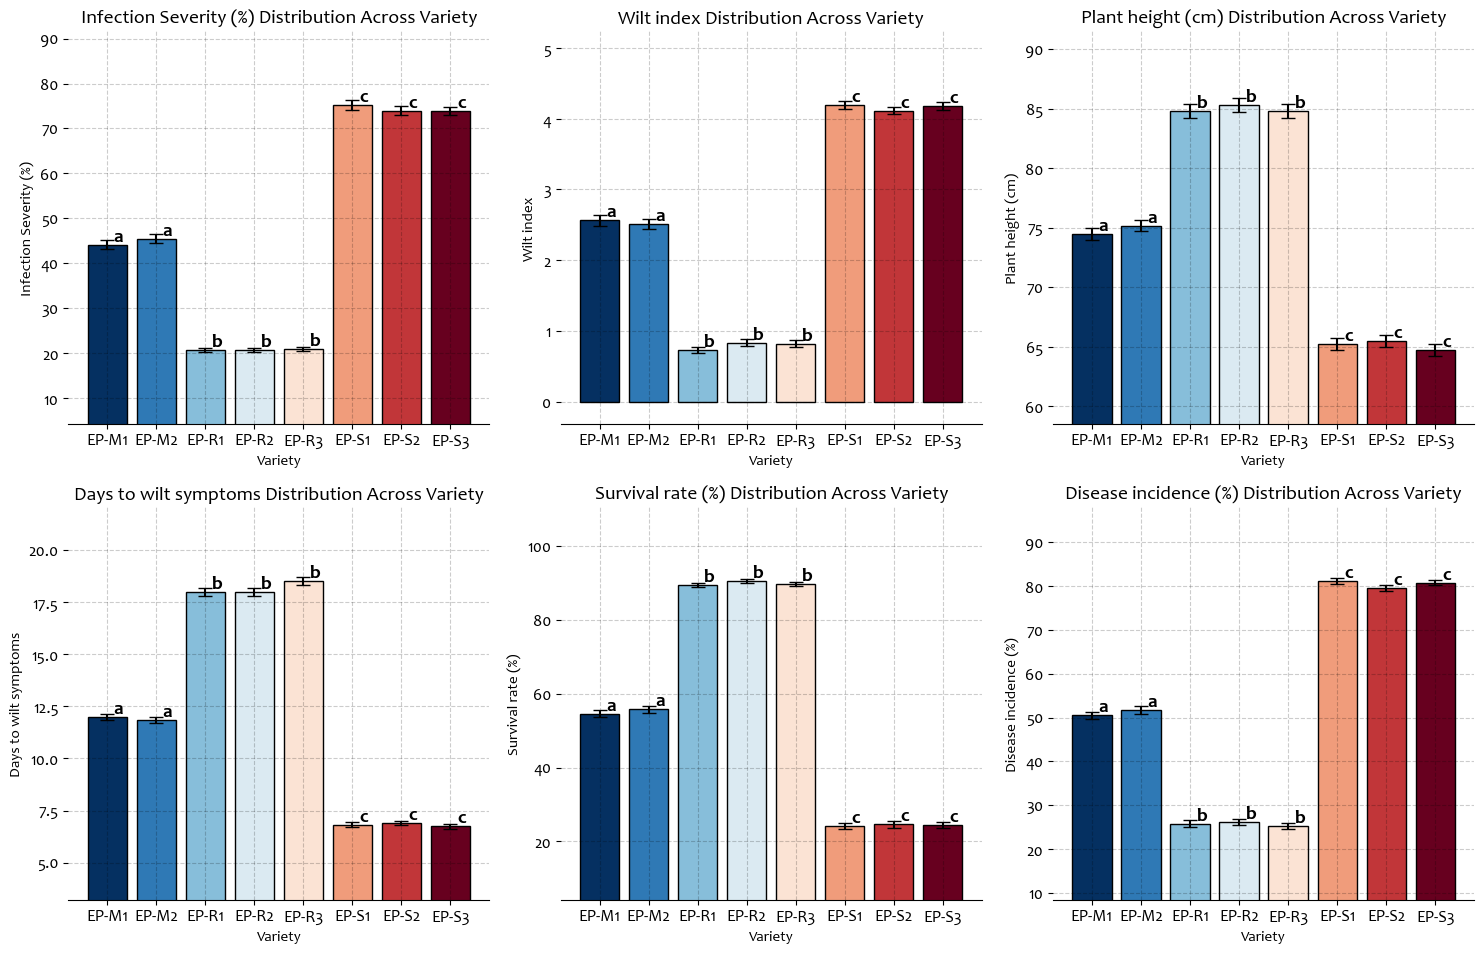

In [60]:
if __name__ == "__main__":
    FACTOR = 'Variety'
    ANALYSIS_METRICS = df.select_dtypes(include=[np.number]).columns.tolist()[1:]
    fig = compact_letters_plot(df, ANALYSIS_METRICS, FACTOR)
    fig.savefig("./outputs/figures/Compact Letters Plots.png")

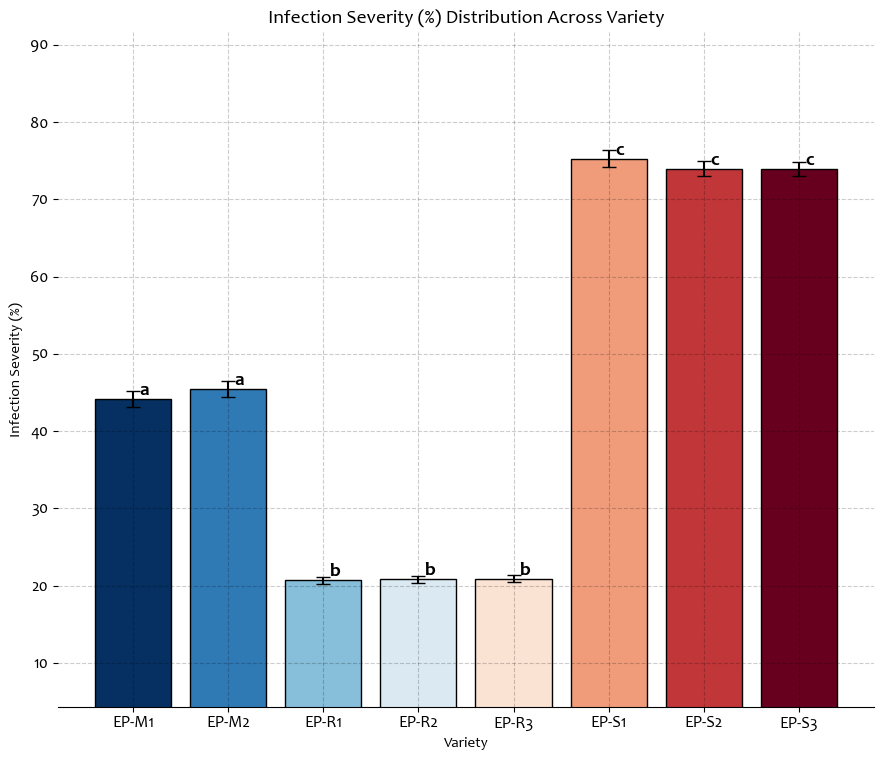

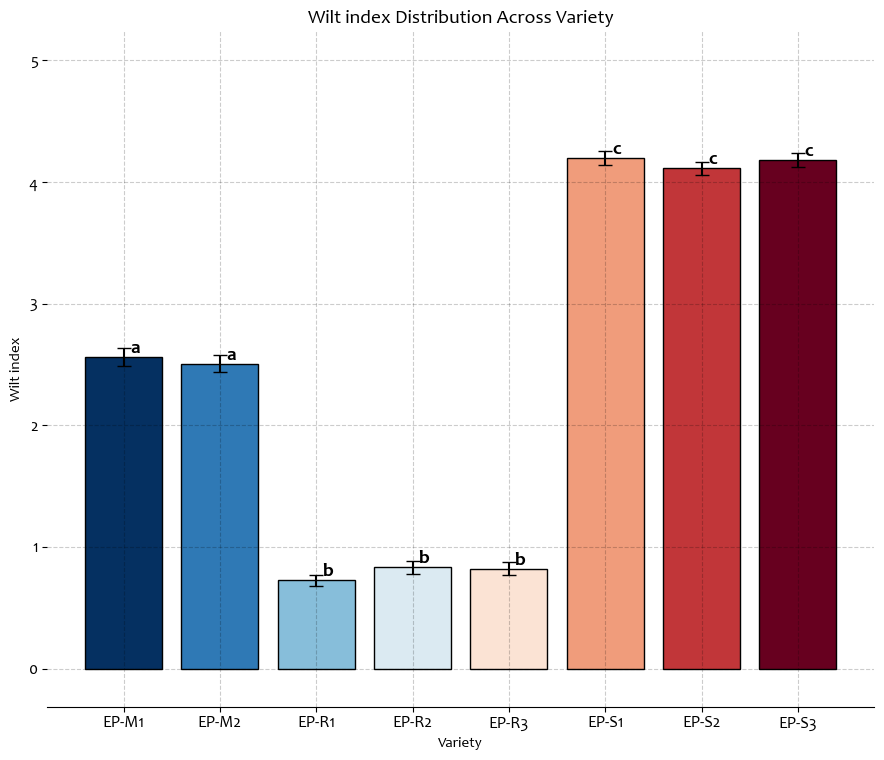

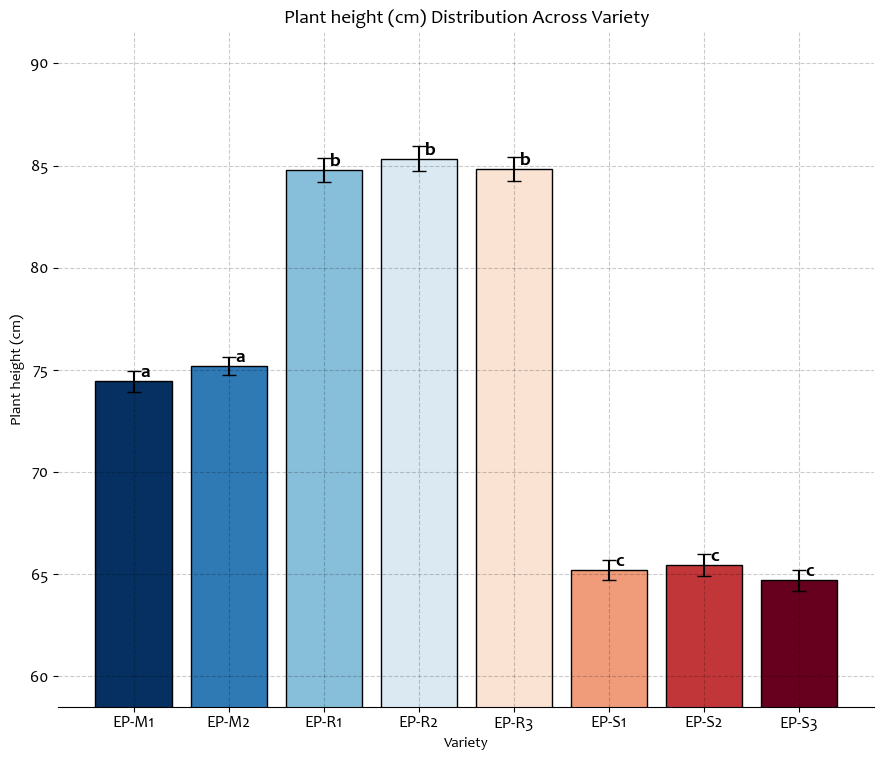

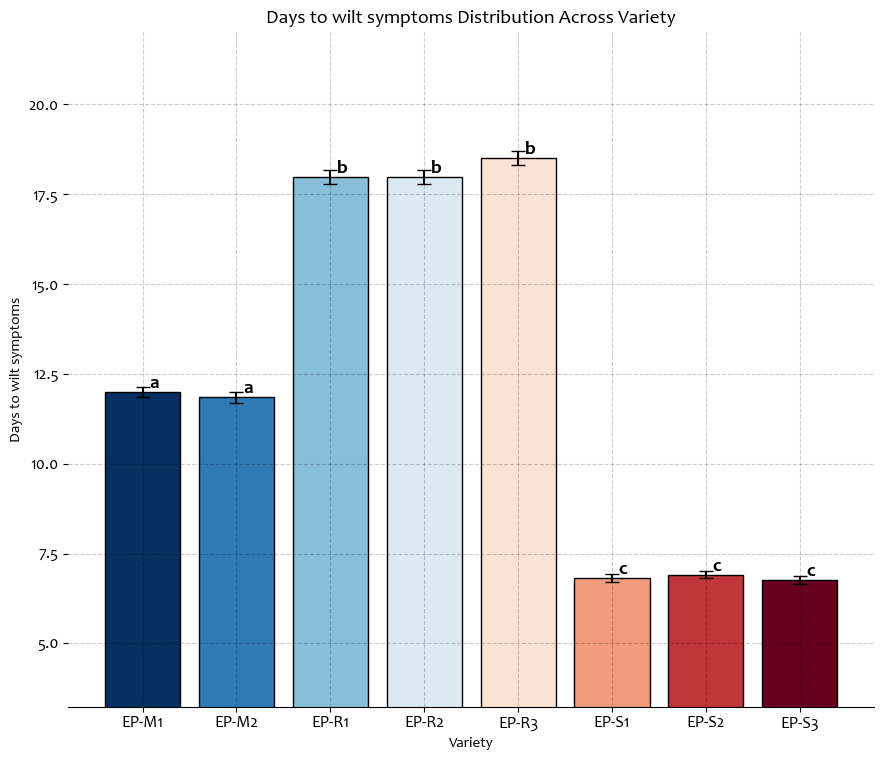

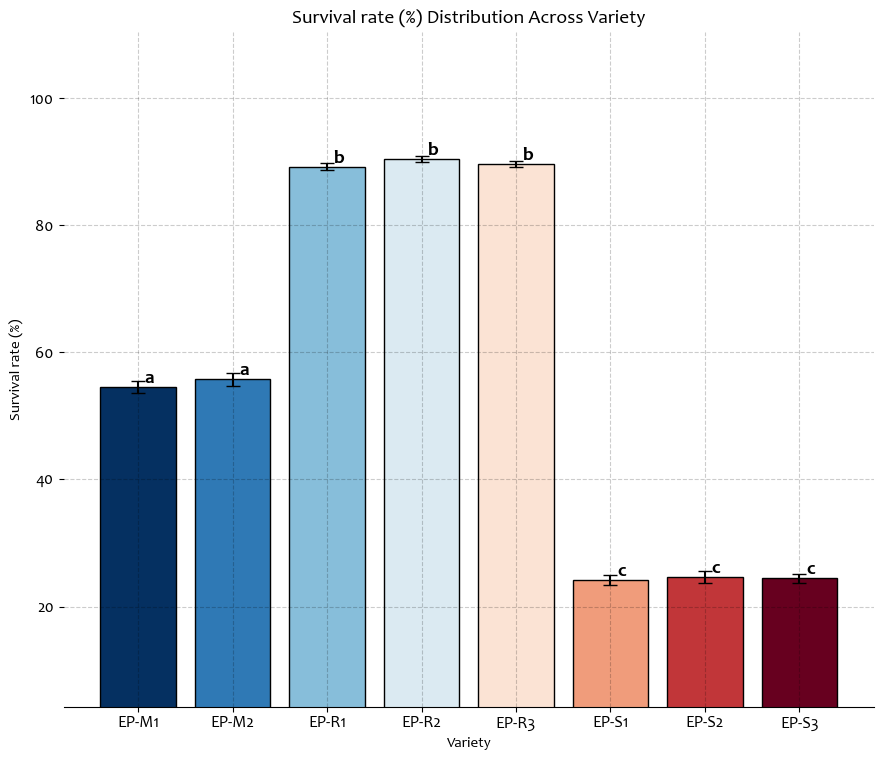

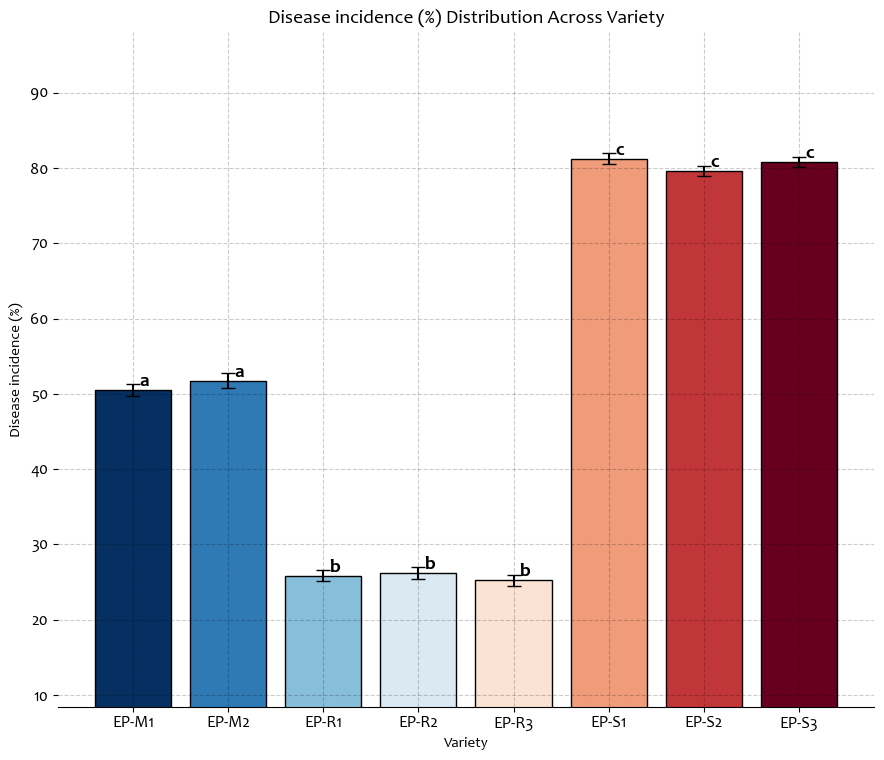

In [59]:
if __name__ == "__main__":
    FACTOR = 'Variety'
    ANALYSIS_METRICS = df.select_dtypes(include=[np.number]).columns.tolist()[1:]
    for METRIC in ANALYSIS_METRICS:
        METRIC_LIST = [METRIC]
        fig = compact_letters_plot(df, METRIC_LIST, FACTOR)
        fig.savefig(f"./outputs/figures/{METRIC}.png")

---

This analysis was performed by **Jabulente**, a passionate and dedicated data analyst with a strong commitment to using data to drive meaningful insights and solutions. For inquiries, collaborations, or further discussions, please feel free to reach out via.  

---

<div align="center">  
    
[![GitHub](https://img.shields.io/badge/GitHub-Jabulente-black?logo=github)](https://github.com/Jabulente)  [![LinkedIn](https://img.shields.io/badge/LinkedIn-Jabulente-blue?logo=linkedin)](https://linkedin.com/in/jabulente-208019349)  [![Email](https://img.shields.io/badge/Email-jabulente@hotmail.com-red?logo=gmail)](mailto:Jabulente@hotmail.com)  

</div>

<h1 style='font-size: 35px; color: black; font-family: French Script MT; font-weight: 700; text-align: center'>Data to Drive Meaningful Insights and Solutions</h1>

<h1 style='font-size: 55px; color: red; font-family: Colonna MT; font-weight: 700; text-align: center'>THE END</h1>